In [23]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

import pathlib
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix
import seaborn as sns
import datetime

In [2]:
# import zipfile

# # Unzip the archive into the "datasets" folder
# local_zip = './merged-datasets.zip'
# zip_ref = zipfile.ZipFile(local_zip, 'r')
# zip_ref.extractall()
# zip_ref.close()

In [3]:
# Directory Management for Raw Image datasets
data_dir_raw_image = 'datasets/raw image'
data_dir_raw_image = pathlib.Path(data_dir_raw_image)
raw_durian_images_dict = {
    'ripe' : list(data_dir_raw_image.glob('ripe/*')),
    'unripe' : list(data_dir_raw_image.glob('unripe/*')),
} 
raw_durian_labels_dict = {
    'ripe' : 0,
    'unripe' : 1
}
list(data_dir_raw_image.glob('*/*.jpg'))[:5]

[WindowsPath('datasets/raw image/ripe/ripe_0.jpg'),
 WindowsPath('datasets/raw image/ripe/ripe_1.jpg'),
 WindowsPath('datasets/raw image/ripe/ripe_10.jpg'),
 WindowsPath('datasets/raw image/ripe/ripe_11.jpg'),
 WindowsPath('datasets/raw image/ripe/ripe_12.jpg')]

In [4]:
# Directory Management for Gas datasets
data_dir_gas = 'datasets/aroma'
data_dir_gas = pathlib.Path(data_dir_gas)
durian_gas_dict = {
    'ripe' : list(data_dir_gas.glob('ripe/*')),
    'unripe' : list(data_dir_gas.glob('unripe/*')),
} 
gas_labels_dict = {
    'ripe' : 0,
    'unripe' : 1
}
list(data_dir_gas.glob('*/*.png'))[:5]

[WindowsPath('datasets/aroma/ripe/heatmap_10_percobaan_1.png'),
 WindowsPath('datasets/aroma/ripe/heatmap_10_percobaan_2.png'),
 WindowsPath('datasets/aroma/ripe/heatmap_10_percobaan_3.png'),
 WindowsPath('datasets/aroma/ripe/heatmap_10_percobaan_4.png'),
 WindowsPath('datasets/aroma/ripe/heatmap_10_percobaan_5.png')]

In [5]:
X_raw, y_raw = [], []
output_folder = "resized_images"
for durian_ripeness, images in raw_durian_images_dict.items():
    for index, image in enumerate(images):
        img = cv2.imread(str(image))
        resized_img = cv2.resize(img,(200,200))
        X_raw.append(resized_img)
        y_raw.append(raw_durian_labels_dict[durian_ripeness])
        # Uncomment if you want to check all the resized images
        # output_name = f"{durian_ripeness}_{index}.jpg"
        # output_path = os.path.join(output_folder, output_name)
        # cv2.imwrite(output_path, resized_img)
X_raw = np.array(X_raw)
y_raw = np.array(y_raw)
len(y_raw)

100

In [6]:
X_gas, y_gas = [], []
for durian_ripeness, images in durian_gas_dict.items():
    for index, image in enumerate(images):
        img = cv2.imread(str(image))
        resized_img = cv2.resize(img,(200,200))
        X_gas.append(resized_img)
        y_gas.append(gas_labels_dict[durian_ripeness])
X_gas = np.array(X_gas)
y_gas = np.array(y_gas)
y_gas
len(y_gas)

100

In [7]:
from sklearn.model_selection import train_test_split
X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(X_raw, y_raw, train_size=0.7)
X_train_gas, X_test_gas, y_train_gas, y_test_gas = train_test_split(X_gas, y_gas, train_size=0.7)

# Scaling Raw dataset
X_train_scaled_raw = X_train_raw /255
X_test_scaled_raw = X_test_raw /255
# Scaling Gas dataset
X_train_scaled_gas = X_train_gas /255
X_test_scaled_gas = X_test_gas /255

In [8]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Flatten, Dense, concatenate
from tensorflow.keras.models import Model

input_shape_raw = (200, 200, 3)  
input_shape_gas = (200, 200, 3)  

# Define two separate input layers
input_raw = Input(shape=input_shape_raw)
input_gas = Input(shape=input_shape_gas)

In [9]:
convDim = 3  # Define the convolution dimension

In [10]:
# Convolution layer for Raw dataset
conv1_raw = Conv2D(16, (convDim, convDim), activation='relu', input_shape=input_shape_raw)(input_raw)
pool1_raw = MaxPooling2D(2, 2)(conv1_raw)

conv2_raw = Conv2D(32, (convDim, convDim), activation='relu')(pool1_raw)
pool2_raw = MaxPooling2D(2, 2)(conv2_raw)

flat_raw = Flatten()(pool2_raw)

In [11]:
# Convolution layer for Gas dataset
conv1_gas = Conv2D(16, (convDim, convDim), activation='relu', input_shape=input_shape_gas)(input_gas)
pool1_gas = MaxPooling2D(2, 2)(conv1_gas)

conv2_gas = Conv2D(32, (convDim, convDim), activation='relu')(pool1_gas)
pool2_gas = MaxPooling2D(2, 2)(conv2_gas)

flat_gas = Flatten()(pool2_gas)

In [12]:
# Concatenate the flattened outputs
merged = concatenate([flat_raw, flat_gas])

In [13]:
# Fully Connected Layer
fc2 = Dense(128, activation='relu')(merged)
fc3 = Dense(64, activation='relu')(fc2)
output = Dense(1, activation='sigmoid')(fc3)

# Create the model
model = Model(inputs=[input_raw, input_gas], outputs=output)

In [14]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
from tensorflow.keras.utils import plot_model

# Print model summary
# model.summary()
plot_model(model, to_file='custom-cnn.png', show_shapes=True, show_layer_names=True)


You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [15]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    # Check the loss
    if(logs.get('accuracy') == 1.0):

      # Stop if threshold is met
      print("\nAccuracy is reached than 1.0 so cancelling training!")
      self.model.stop_training = True

# Instantiate class
callbacks = myCallback()
# callbacks=callbacks

In [16]:
# Train the model
model_fit = model.fit(
 ( X_train_scaled_raw, X_train_scaled_gas), 
 y_train_raw, 
 epochs=50,
 validation_data=(
        ( X_test_scaled_raw, X_test_scaled_gas), 
        ( y_test_raw, y_test_gas)
    ),
#  callbacks=callbacks
 )

Epoch 1/50


3/3 [==============================] - 2s 283ms/step - loss: 3.0214 - accuracy: 0.5286 - val_loss: 0.8055 - val_accuracy: 0.6333
Epoch 2/50
3/3 [==============================] - 1s 192ms/step - loss: 0.9784 - accuracy: 0.5000 - val_loss: 1.1613 - val_accuracy: 0.3667
Epoch 3/50
3/3 [==============================] - 1s 200ms/step - loss: 0.7844 - accuracy: 0.6143 - val_loss: 0.6642 - val_accuracy: 0.6000
Epoch 4/50
3/3 [==============================] - 1s 192ms/step - loss: 0.6459 - accuracy: 0.7143 - val_loss: 0.6373 - val_accuracy: 0.6667
Epoch 5/50
3/3 [==============================] - 1s 192ms/step - loss: 0.5130 - accuracy: 0.9286 - val_loss: 0.5377 - val_accuracy: 0.8000
Epoch 6/50
3/3 [==============================] - 1s 183ms/step - loss: 0.3643 - accuracy: 0.9000 - val_loss: 0.7007 - val_accuracy: 0.5000
Epoch 7/50
3/3 [==============================] - 1s 195ms/step - loss: 0.2508 - accuracy: 0.9286 - val_loss: 0.2798 - val_accuracy: 0.9333
Epoch 8/50
3/3 [==

In [17]:
loss, accuracy = model.evaluate([X_test_scaled_raw, X_test_scaled_gas], [y_test_raw, y_test_gas])
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

1/1 [==============================] - 0s 67ms/step - loss: 0.0661 - accuracy: 0.9667
Test Loss: 0.06611193716526031
Test Accuracy: 0.9666666388511658


In [18]:
predictions = model.predict([X_test_scaled_raw, X_test_scaled_gas])
predictions = np.round(predictions,2)
predictions

1/1 [==============================] - 0s 122ms/step


array([[1.  ],
       [0.  ],
       [1.  ],
       [0.99],
       [1.  ],
       [1.  ],
       [0.  ],
       [0.17],
       [0.96],
       [0.  ],
       [0.  ],
       [0.03],
       [0.  ],
       [0.  ],
       [1.  ],
       [0.  ],
       [0.  ],
       [0.  ],
       [0.  ],
       [0.  ],
       [0.  ],
       [1.  ],
       [0.  ],
       [0.  ],
       [0.04],
       [1.  ],
       [0.  ],
       [1.  ],
       [0.03],
       [0.04]], dtype=float32)

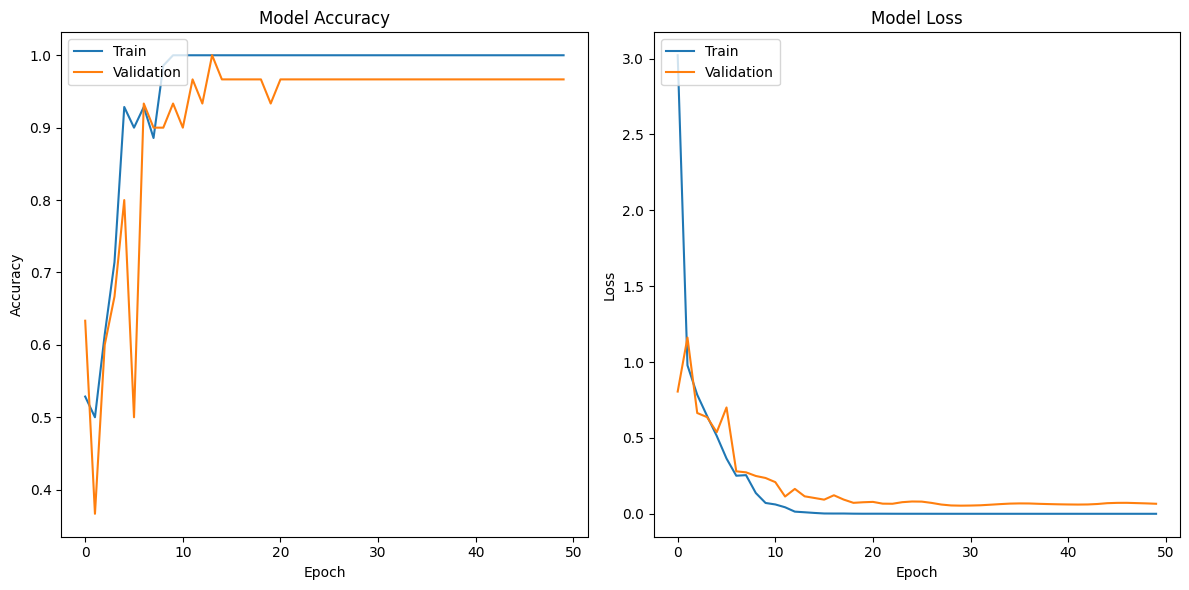

In [24]:
# Plot training and validation history
plt.figure(figsize=(12, 6))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(model_fit.history['accuracy'])
plt.plot(model_fit.history['val_accuracy'])  # Add validation accuracy
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(model_fit.history['loss'])
plt.plot(model_fit.history['val_loss'])  # Add validation loss
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
# Get current date and time
now = datetime.datetime.now()

# Format the date-time string as 'MMDDYYYY-HHMM'
date_time_str = now.strftime("%d%m%Y-%H%M")

# Save the plot with the specified name format
plt.savefig(f"{date_time_str}.png")

plt.show()


1/1 [==============================] - 0s 85ms/step


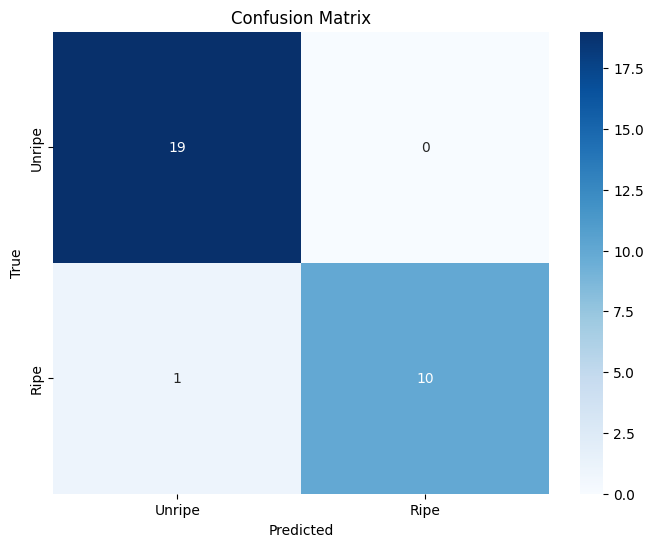

In [22]:
from sklearn.metrics import confusion_matrix

# Generate predictions on the test set
y_pred = model.predict([X_test_scaled_raw, X_test_scaled_gas])
y_pred_classes = (y_pred > 0.9).astype(int)  # Assuming it's a binary classification problem

# Assuming y_test contains the true labels for the test set
# Generate the confusion matrix
conf_mat = confusion_matrix(y_test_raw, y_pred_classes)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=['Unripe', 'Ripe'], yticklabels=['Unripe', 'Ripe'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()